# Bioinformatics Project - "Exploring the Mechanisms behind *S. epidermidis* Resistance to Vancomycin using Bioinformatics Analysis"

*Code developed by Laís Carvalho (pg52536) 2024*

**Object of the code:**

- Process the expression data in order to obtain a list of overexpressed genes;

- Obtain the graphic representation of the enriched pathways.  

### Process the expression data in order to obtain a list of overexpressed genes

The expression data is in an excel file. 

- The first function created (`upload_xlsx_processing()`) has the functionality of uploading the excel file and selecting only the names of the genes that follow the input parameters. 

Function input:
1. file_path - path of the xlsx file you want to analyze (expression data).
2. FDR_pvalue - determine the significance level to be considered in the statistical test
3. FoldChange - value representing the Fold Change you want to analyze
4. Upregulation - boolean argument, determine whether the analysis is upregulation or downregulation

In addition to forming a txt file with the names of the overexpressed or upregulated genes, the function returns the list of genes and the number of genes in the list.

In [2]:
import pandas as pd
def upload_xlsx_processing(file_path_upload,file_name_output, FDR_pvalue, FoldChange, Upregulation = True):
    data = pd.read_excel(file_path_upload)
    important_columns = ["Feature ID", "Experiment - Fold Change (original values)", "Baggerley's test: IR VAN vs CT original values - FDR p-value correction"]
    df = data[important_columns]
    filtrationFDR = df[df["Baggerley's test: IR VAN vs CT original values - FDR p-value correction"] < FDR_pvalue]
    if Upregulation:
        filtration_FC = filtrationFDR[filtrationFDR["Experiment - Fold Change (original values)"] > FoldChange]
    else:
        filtration_FC = filtrationFDR[filtrationFDR["Experiment - Fold Change (original values)"] < FoldChange]
    column_genes_names = filtration_FC["Feature ID"]
    genes = []
    for x in column_genes_names:
        genes.append(x)

    with open(file_name_output, "w") as file:
        for gene in genes:
            file.write(gene + "\n")
    return genes, len(genes)

- To match the gene names with the identifiers used in STRING and process the information obtained, the following function (`string_file_processing()`) was developed. 

The function takes as input the path of the document obtained from STRING, processes this document and formulates a txt file with the ids, returning a list of these ids.

In [3]:
def string_file_processing(file_name_input, file_name_output):
    d = pd.read_csv(file_name, sep="\t", header=None, names=["Feature ID", "String accession", "Official name", "Description"])
    d["String accession"] = d["String accession"].str.replace("176279.", "")
    data = d[~d["Feature ID"].str.contains("tRNA")]
    # remove the NAs, usually pseudogenes
    data.dropna(subset=["Description"], inplace=True)
    column_genes_names = data["String accession"]

    with open(file_name_output, "w") as file:
         for gene in column_genes_names:
            file.write(gene + "\n")
    return [x for x in column_genes_names][1:]

###### Application of data processing

- Data processing for the strain: PT11011

In [17]:
# Processing the data and obtaining the final txt file to be applied in ShinyGO. 
file_path = "CT vs IR VAN PT11011.xlsx" # Analysis of strain PT11011 
results = upload_xlsx_processing(file_path, "genes_PT11011_raw.txt", 0.05, 2, Upregulation = True)
file_name = "string_mapping_PT11011.tsv"
gene_list_PT11011 = string_file_processing(file_name, "genes_ids_PT11011.txt")
print("Final number of genes:", len(gene_list_PT11011), "\n","Initial number of genes:", results[1]) # It was observed that 2 genes were tRNA or pseudogenes.

Final number of genes: 148 
 Initial number of genes: 150


- Data processing for the strain: PT12035

In [18]:
# Processing the data and obtaining the final txt file to be applied in ShinyGO.
file_path = "CT vs IR VAN PT12035.xlsx" # Analysis of strain PT11011 
results = upload_xlsx_processing(file_path, "genes_PT12035_raw.txt", 0.05, 2, Upregulation = True)
file_name = "string_mapping_PT12035.tsv"
gene_list_PT12035 = string_file_processing(file_name, "genes_ids_PT12035.txt")
print("Final number of genes:", len(gene_list_PT12035), "\n","Initial number of genes:", results[1])

Final number of genes: 84 
 Initial number of genes: 86


### Obtain the graphic representation of the enriched pathways

The ShinyGO tool allows graphical visualization of the enriched pathways. However, limitations such as the difficulty in integrating data from different databases, the lack of annotations on the organism studied or the outdated nature of the online tool can interfere with the results and make it impossible to visualize the pathways graphically.

To obtain the graphs of the enriched paths, the following functions were developed: 

In [9]:
# Useful python packages
import pandas as pd
from Bio.KEGG import REST
import re
from bioservices import KEGG

In [12]:
def gene_name_format(gene_list, term):
    """Function that receives a list of genes and adds the specified term (usually the identification term of the study organism used in KEGG, accompanied by “:”), 
    returns the formatted list of genes"""
    gene_list_form = []
    for gene in gene_list:
        gene_list_form.append(term + gene)
    return gene_list_form

def get_pathways_shinyGO(file_path, term):
    """It uploads the table (result) obtained to ShinyGO and formulates a dictionary 
    that stores the name of the enriched pathway as a key and the list of genes associated with this pathway as values"""
    df_ShinyGO = pd.read_csv(file_path)
    pathway_dict = {}
    for index, row in df_ShinyGO.iterrows():
        pathway = row['Pathway']
        gene = row['Genes']

        if pathway not in pathway_dict:
            pathway_dict[pathway] = []

        for x in gene.split(" "):
            pathway_dict[pathway].append(term +x)
    return pathway_dict

def serach_genes_pathways_kegg(gene_list, term):
    """This fuction searches for KEGG pathways associated with a given list of genes. 
    The function takes a list of genes as input and returns a dictionary where the keys are the gene 
    IDs and the values are lists of KEGG pathway IDs associated with each gene"""
    dic = {}
    for id_gene in gene_name_format(gene_list, term):
        result = REST.kegg_get(id_gene).read()
        if "PATHWAY" in result:
            linhas = result.split('\n')
            info_pathway = []
            
            em_pathway = False

            
            for linha in linhas:
                if linha.startswith("PATHWAY"):
                    em_pathway = True
                    
                    info_pathway.append(linha)
                elif em_pathway and linha.strip() and linha.startswith(" "):  
                   
                    info_pathway.append(linha)
                else:
                    em_pathway = False

            
            info_pathway_str = '\n'.join(info_pathway)
            padrao = r"ser\d{5}"
            ocorrencias = re.findall(padrao, info_pathway_str)
            dic[id_gene] = ocorrencias
    else: pass
    return dic

def get_pathway_name(id_pathway):
    """The function takes a KEGG pathway ID as input and returns the name of the pathway as a string"""
    dic = {}
    result = REST.kegg_get(id_pathway).read()
    linhas = result.split("\n")
    res = ""
    for linha in linhas:
        if linha.startswith("NAME"):
            res = linha
    import re
    nome = re.search(r'NAME\s+(.+)', res).group(1)
    return nome

def get_pathways_kegg_dict(genes_pathways):
    """The function takes a dictionary of genes and their associated pathways as input and returns a new dictionary 
    where the keys are the pathway IDs and the values are tuples containing the number of genes associated with the pathway, 
    the name of the pathway, and a list of genes associated with the pathway"""
    vias = {}
    for g in genes_pathways.keys():
        for via in genes_pathways[g]:
            if via not in vias:
                vias[via] = [g]
            else: 
                vias[via].append(g)

    x = dict(sorted(vias.items(), key=lambda item: len(item[1]), reverse = True))
    dic = {}
    for via in x.keys():
        dic[via] = (len(x[via]), get_pathway_name(via), x[via])
    return dic

def comparison_kegg_shinygo(dict1, dict2):
    """The function takes two dictionaries as input and returns a new dictionary containing the KEGG pathways that meet certain criteria.
    The function can be used to identify common biological processes or pathways that are affected in both datasets."""
    new_dict = {}
    for k1, (KEGG_count, name, genes1) in dict1.items():
        max_count = 0
        k_max = None
        for k2, genes2 in dict2.items():
            genes_c = set(genes1) & set(genes2)
            count = len(genes_c)
            if count > max_count:
                max_count = count
                k_max = k2
        if k_max:
            new_dict[k1] = (KEGG_count, name, k_max, max_count)
            
    dic_final = {}
    for keys, (KEGG_count, name, _, max_count) in new_dict.items():
        if KEGG_count >= 2 and max_count/KEGG_count >= 0.5:
            dic_final[keys] = (KEGG_count, name)
            
    return dic_final

def relevant_pathways(dict_comparation, general_keys_to_remove, path_dict):
    """The purpose of this function is to filter out irrelevant pathways and create a new dictionary with the relevant pathways and their associated genes"""
    keys_to_remove = general_keys_to_remove
    dic_final = {chave: valor for chave, valor in dict_comparation.items() if chave not in keys_to_remove}
    
    dict_final_wgenes = {}
    for k in dic_final.keys():
        dict_final_wgenes[k] = path_dict[k]
    return dict_final_wgenes

def get_url_pathway(target_path, target_genes, color_backgroud, color_line):
    """The purpose of this function is to generate a URL that can be used to visualize a KEGG pathway with specific genes highlighted"""
    s = KEGG()
    target_kos = {}
    for gene in target_genes:
        target_kos[gene] = "{},{}".format(color_backgroud, color_line)
    url = s.show_pathway(target_path, scale= None, keggid=target_kos, show=True)
    return url

##### Aplication

- PT11011:

In [19]:
# uploading ShinyGO results
file_path = 'enrichment_PT11011.csv'
pathways_shinygo = get_pathways_shinyGO(file_path, "ser:")
# Search for the pathways related to the genes obtained from processing the data in the KEGG database.
kegg_search = serach_genes_pathways_kegg(gene_list_PT11011, "ser:")

In [20]:
# From the search obtained in KEGG, form the dictionary for comparison with the result in ShinyGO
pathways_kegg = get_pathways_kegg_dict(kegg_search)
pathways_kegg

{'ser03010': (35,
  'Ribosome - Staphylococcus epidermidis RP62A (MRSE)',
  ['ser:SERP0179',
   'ser:SERP1828',
   'ser:SERP1831',
   'ser:SERP1830',
   'ser:SERP1819',
   'ser:SERP1816',
   'ser:SERP0180',
   'ser:SERP0178',
   'ser:SERP0181',
   'ser:SERP1799',
   'ser:SERP1821',
   'ser:SERP1824',
   'ser:SERP1815',
   'ser:SERP1242',
   'ser:SERP1211',
   'ser:SERP1826',
   'ser:SERP1829',
   'ser:SERP1820',
   'ser:SERP1823',
   'ser:SERP1813',
   'ser:SERP0718',
   'ser:SERP1243',
   'ser:SERP0823',
   'ser:SERP1825',
   'ser:SERP1284',
   'ser:SERP1814',
   'ser:SERP1817',
   'ser:SERP1798',
   'ser:SERP1832',
   'ser:SERP1806',
   'ser:SERP1807',
   'ser:SERP1818',
   'ser:SERP1822',
   'ser:SERP0046',
   'ser:SERP1827']),
 'ser01100': (17,
  'Metabolic pathways - Staphylococcus epidermidis RP62A (MRSE)',
  ['ser:SERP1810',
   'ser:SERP2176',
   'ser:SERP2177',
   'ser:SERP2185',
   'ser:SERP2192',
   'ser:SERP2191',
   'ser:SERP0152',
   'ser:SERP0109',
   'ser:SERP1166',
   '

In [21]:
# Compare the results obtained and obtain the important pathways
compared_dicts = comparison_kegg_shinygo(pathways_kegg, pathways_shinygo)
compared_dicts

{'ser03010': (35, 'Ribosome - Staphylococcus epidermidis RP62A (MRSE)'),
 'ser01100': (17,
  'Metabolic pathways - Staphylococcus epidermidis RP62A (MRSE)'),
 'ser02010': (8, 'ABC transporters - Staphylococcus epidermidis RP62A (MRSE)'),
 'ser01110': (6,
  'Biosynthesis of secondary metabolites - Staphylococcus epidermidis RP62A (MRSE)'),
 'ser01230': (6,
  'Biosynthesis of amino acids - Staphylococcus epidermidis RP62A (MRSE)'),
 'ser00920': (5,
  'Sulfur metabolism - Staphylococcus epidermidis RP62A (MRSE)'),
 'ser01120': (5,
  'Microbial metabolism in diverse environments - Staphylococcus epidermidis RP62A (MRSE)'),
 'ser00270': (5,
  'Cysteine and methionine metabolism - Staphylococcus epidermidis RP62A (MRSE)'),
 'ser00730': (3,
  'Thiamine metabolism - Staphylococcus epidermidis RP62A (MRSE)'),
 'ser01240': (3,
  'Biosynthesis of cofactors - Staphylococcus epidermidis RP62A (MRSE)'),
 'ser02020': (3,
  'Two-component system - Staphylococcus epidermidis RP62A (MRSE)'),
 'ser00552'

In [22]:
# Remove general, non-fundamental pathways to conclusions
keys_to_remove = ['ser01100', 'ser01110', 'ser01120']
relevant_paths = relevant_pathways(compared_dicts, keys_to_remove, pathways_kegg)
relevant_paths

{'ser03010': (35,
  'Ribosome - Staphylococcus epidermidis RP62A (MRSE)',
  ['ser:SERP0179',
   'ser:SERP1828',
   'ser:SERP1831',
   'ser:SERP1830',
   'ser:SERP1819',
   'ser:SERP1816',
   'ser:SERP0180',
   'ser:SERP0178',
   'ser:SERP0181',
   'ser:SERP1799',
   'ser:SERP1821',
   'ser:SERP1824',
   'ser:SERP1815',
   'ser:SERP1242',
   'ser:SERP1211',
   'ser:SERP1826',
   'ser:SERP1829',
   'ser:SERP1820',
   'ser:SERP1823',
   'ser:SERP1813',
   'ser:SERP0718',
   'ser:SERP1243',
   'ser:SERP0823',
   'ser:SERP1825',
   'ser:SERP1284',
   'ser:SERP1814',
   'ser:SERP1817',
   'ser:SERP1798',
   'ser:SERP1832',
   'ser:SERP1806',
   'ser:SERP1807',
   'ser:SERP1818',
   'ser:SERP1822',
   'ser:SERP0046',
   'ser:SERP1827']),
 'ser02010': (8,
  'ABC transporters - Staphylococcus epidermidis RP62A (MRSE)',
  ['ser:SERP0099',
   'ser:SERP0246',
   'ser:SERP1951',
   'ser:SERP1952',
   'ser:SERP2003',
   'ser:SERP2004',
   'ser:SERP2005',
   'ser:SERP2081']),
 'ser01230': (6,
  'Bios

In [23]:
# Get the urls with the graphic images and the highlighted genes of interest
for v in relevant_paths:
    url = get_url_pathway(v, relevant_paths[v][2], "yellow", "red")
    print(url)

http://www.kegg.jp/kegg-bin/show_pathway?ser03010/default%3dpink//ser:SERP0179%09yellow,red//ser:SERP1828%09yellow,red//ser:SERP1831%09yellow,red//ser:SERP1830%09yellow,red//ser:SERP1819%09yellow,red//ser:SERP1816%09yellow,red//ser:SERP0180%09yellow,red//ser:SERP0178%09yellow,red//ser:SERP0181%09yellow,red//ser:SERP1799%09yellow,red//ser:SERP1821%09yellow,red//ser:SERP1824%09yellow,red//ser:SERP1815%09yellow,red//ser:SERP1242%09yellow,red//ser:SERP1211%09yellow,red//ser:SERP1826%09yellow,red//ser:SERP1829%09yellow,red//ser:SERP1820%09yellow,red//ser:SERP1823%09yellow,red//ser:SERP1813%09yellow,red//ser:SERP0718%09yellow,red//ser:SERP1243%09yellow,red//ser:SERP0823%09yellow,red//ser:SERP1825%09yellow,red//ser:SERP1284%09yellow,red//ser:SERP1814%09yellow,red//ser:SERP1817%09yellow,red//ser:SERP1798%09yellow,red//ser:SERP1832%09yellow,red//ser:SERP1806%09yellow,red//ser:SERP1807%09yellow,red//ser:SERP1818%09yellow,red//ser:SERP1822%09yellow,red//ser:SERP0046%09yellow,red//ser:SERP1827%09y

- Exemple of the URL result

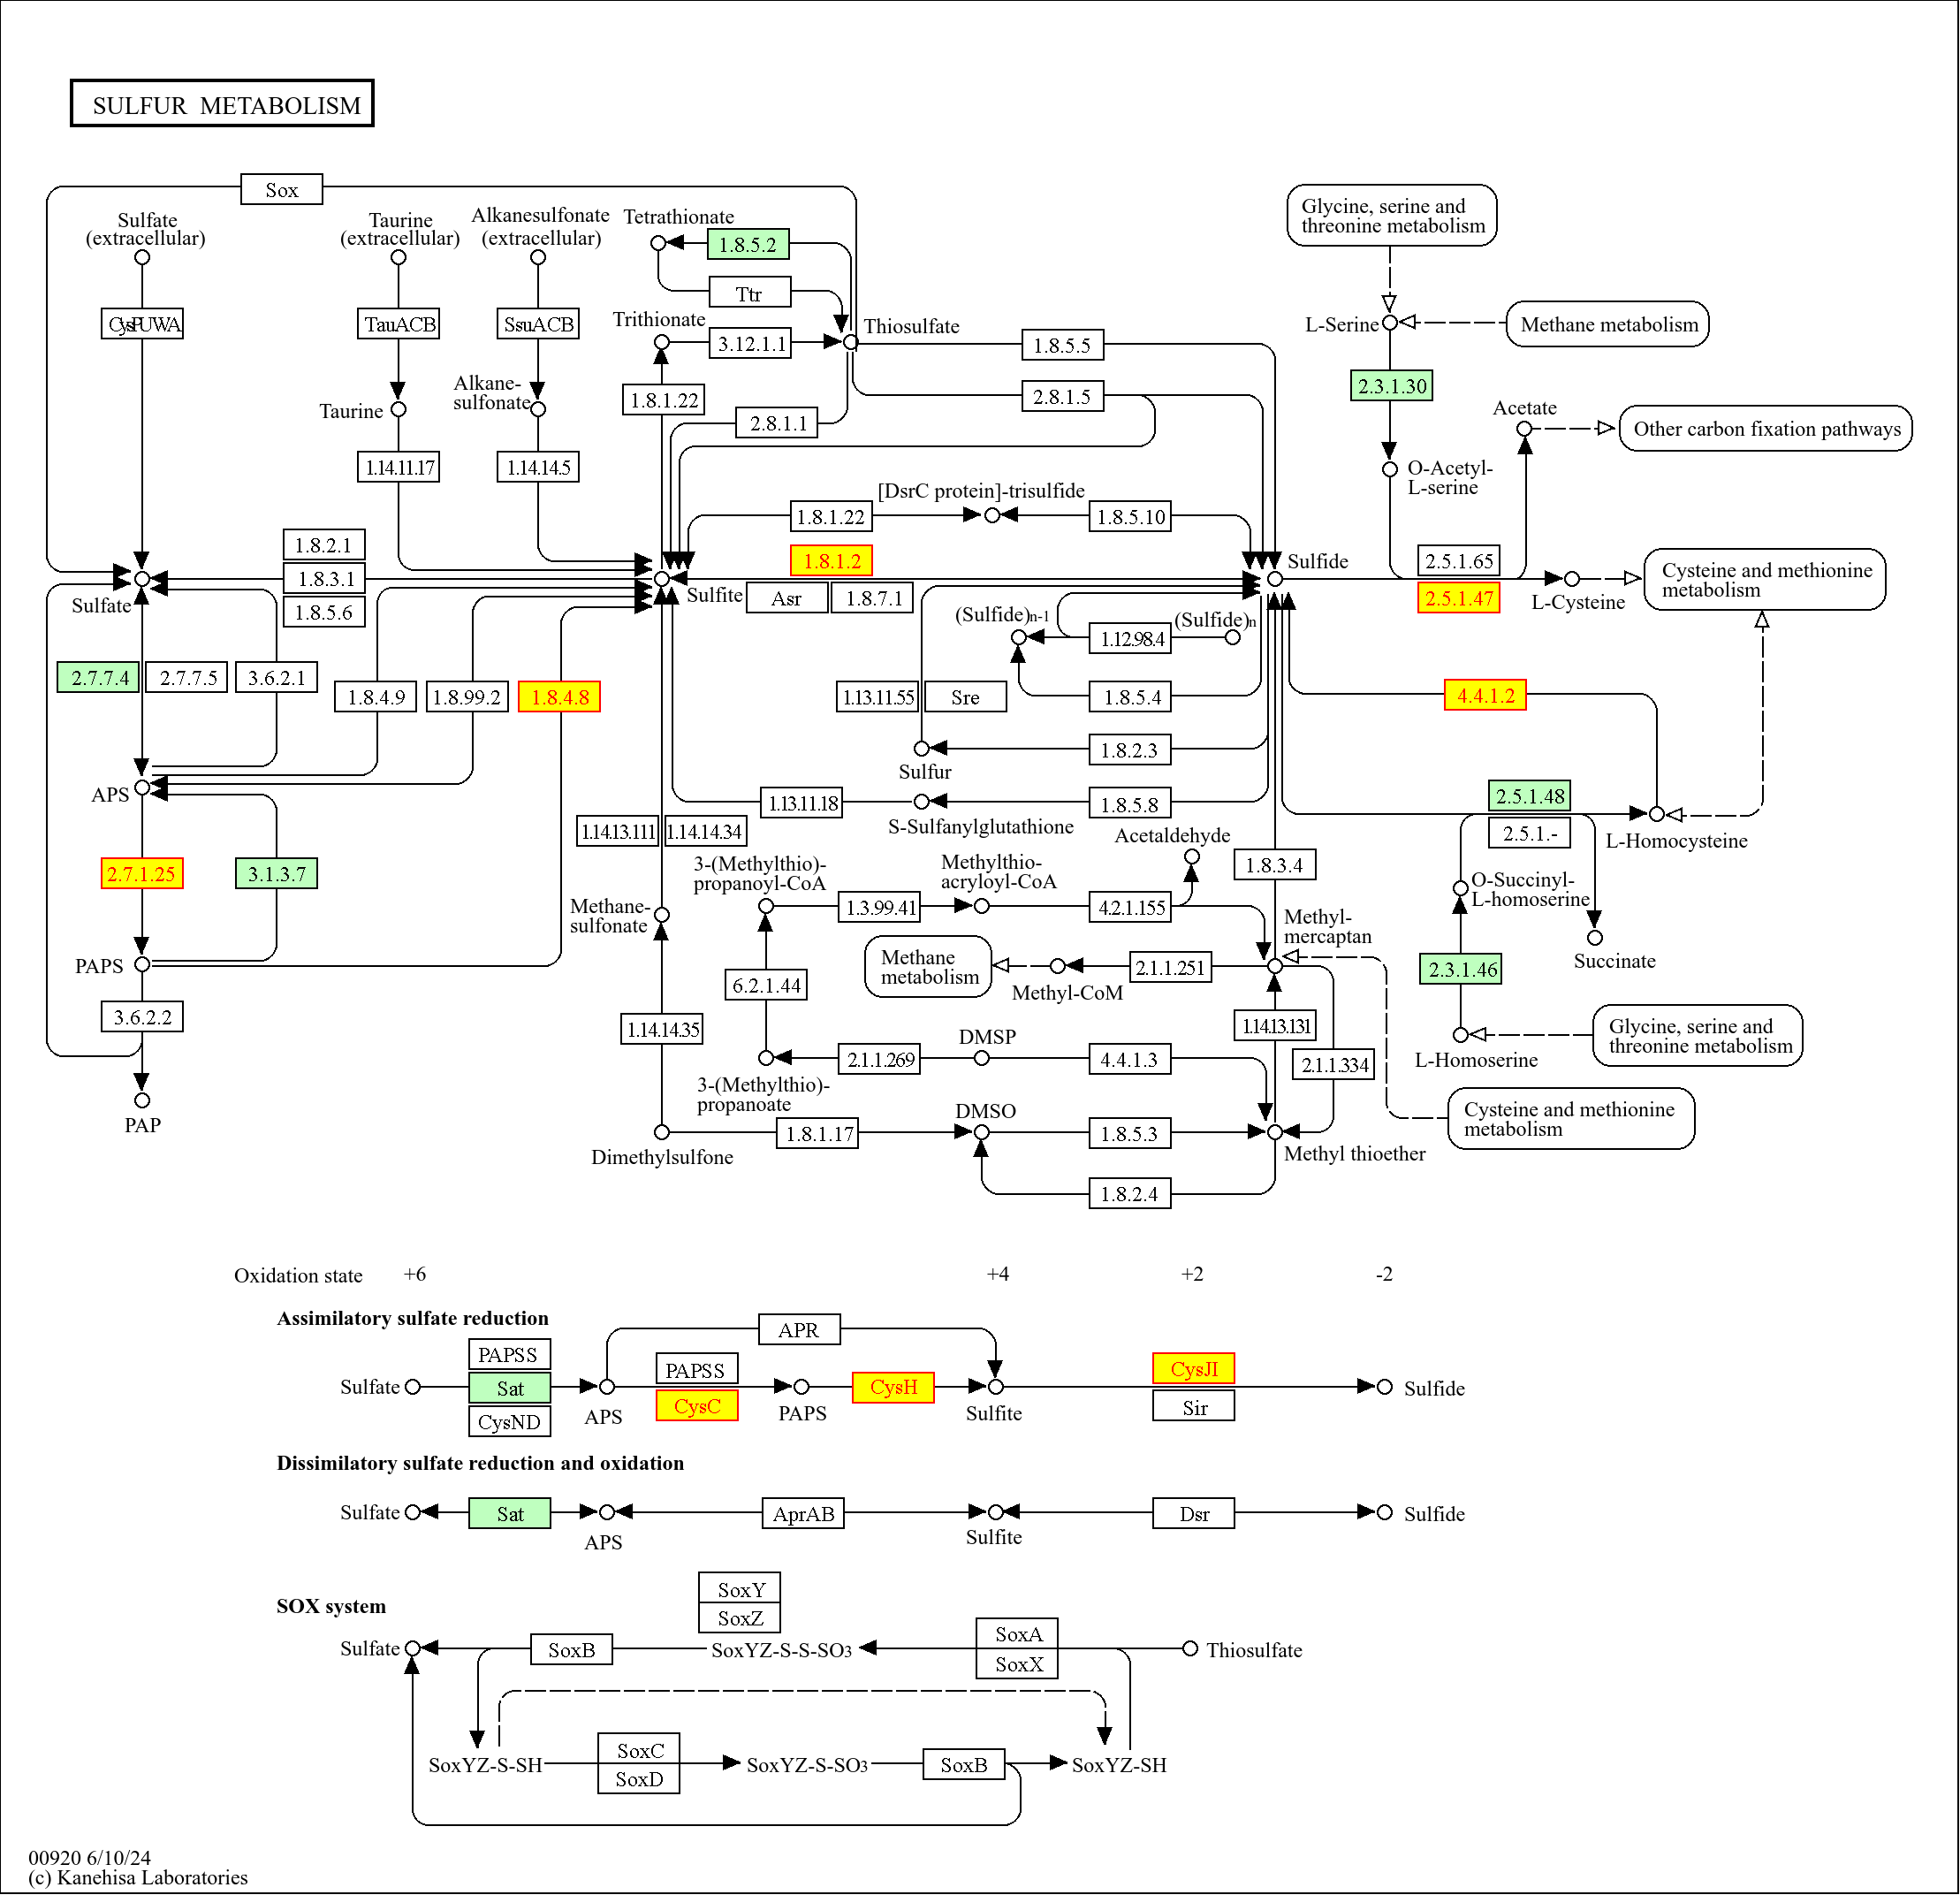

- PT12035

In [24]:
# uploading ShinyGO results
file_path = 'enrichment_PT12035.csv'
pathways_shinygo = get_pathways_shinyGO(file_path, "ser:")
# Search for the pathways related to the genes obtained from processing the data in the KEGG database.
kegg_search = serach_genes_pathways_kegg(gene_list_PT12035, "ser:")

In [25]:
# From the search obtained in KEGG, form the dictionary for comparison with the result in ShinyGO
pathways_kegg = get_pathways_kegg_dict(kegg_search)
pathways_kegg

{'ser02010': (14,
  'ABC transporters - Staphylococcus epidermidis RP62A (MRSE)',
  ['ser:SERP0957',
   'ser:SERP0958',
   'ser:SERP0959',
   'ser:SERP0960',
   'ser:SERP1951',
   'ser:SERP1952',
   'ser:SERP2003',
   'ser:SERP2004',
   'ser:SERP2005',
   'ser:SERP2283',
   'ser:SERP2284',
   'ser:SERP2285',
   'ser:SERP2286',
   'ser:SERP2355']),
 'ser01100': (12,
  'Metabolic pathways - Staphylococcus epidermidis RP62A (MRSE)',
  ['ser:SERP2192',
   'ser:SERP0520',
   'ser:SERP2297',
   'ser:SERP2388',
   'ser:SERP2346',
   'ser:SERP0018',
   'ser:SERP0094',
   'ser:SERP0095',
   'ser:SERP0196',
   'ser:SERP0197',
   'ser:SERP2336',
   'ser:SERP2343']),
 'ser00561': (6,
  'Glycerolipid metabolism - Staphylococcus epidermidis RP62A (MRSE)',
  ['ser:SERP2297',
   'ser:SERP2388',
   'ser:SERP2346',
   'ser:SERP0018',
   'ser:SERP2336',
   'ser:SERP2343']),
 'ser00552': (3,
  'Teichoic acid biosynthesis - Staphylococcus epidermidis RP62A (MRSE)',
  ['ser:SERP0520', 'ser:SERP0521', 'ser:S

In [26]:
# Compare the results obtained and obtain the important pathways
compared_dicts = comparison_kegg_shinygo(pathways_kegg, pathways_shinygo)
compared_dicts

{'ser02010': (14,
  'ABC transporters - Staphylococcus epidermidis RP62A (MRSE)'),
 'ser00561': (6,
  'Glycerolipid metabolism - Staphylococcus epidermidis RP62A (MRSE)'),
 'ser00552': (3,
  'Teichoic acid biosynthesis - Staphylococcus epidermidis RP62A (MRSE)'),
 'ser01503': (3,
  'Cationic antimicrobial peptide (CAMP) resistance - Staphylococcus epidermidis RP62A (MRSE)'),
 'ser02020': (3,
  'Two-component system - Staphylococcus epidermidis RP62A (MRSE)'),
 'ser02024': (3, 'Quorum sensing - Staphylococcus epidermidis RP62A (MRSE)'),
 'ser00040': (2,
  'Pentose and glucuronate interconversions - Staphylococcus epidermidis RP62A (MRSE)')}

In [27]:
# Remove general, non-fundamental pathways to conclusions
keys_to_remove = []
relevant_paths = relevant_pathways(compared_dicts, keys_to_remove, pathways_kegg)
relevant_paths

{'ser02010': (14,
  'ABC transporters - Staphylococcus epidermidis RP62A (MRSE)',
  ['ser:SERP0957',
   'ser:SERP0958',
   'ser:SERP0959',
   'ser:SERP0960',
   'ser:SERP1951',
   'ser:SERP1952',
   'ser:SERP2003',
   'ser:SERP2004',
   'ser:SERP2005',
   'ser:SERP2283',
   'ser:SERP2284',
   'ser:SERP2285',
   'ser:SERP2286',
   'ser:SERP2355']),
 'ser00561': (6,
  'Glycerolipid metabolism - Staphylococcus epidermidis RP62A (MRSE)',
  ['ser:SERP2297',
   'ser:SERP2388',
   'ser:SERP2346',
   'ser:SERP0018',
   'ser:SERP2336',
   'ser:SERP2343']),
 'ser00552': (3,
  'Teichoic acid biosynthesis - Staphylococcus epidermidis RP62A (MRSE)',
  ['ser:SERP0520', 'ser:SERP0521', 'ser:SERP0198']),
 'ser01503': (3,
  'Cationic antimicrobial peptide (CAMP) resistance - Staphylococcus epidermidis RP62A (MRSE)',
  ['ser:SERP0520', 'ser:SERP0521', 'ser:SERP2252']),
 'ser02020': (3,
  'Two-component system - Staphylococcus epidermidis RP62A (MRSE)',
  ['ser:SERP0520', 'ser:SERP0521', 'ser:SERP0960'])

In [28]:
# Get the urls with the graphic images and the highlighted genes of interest
for v in relevant_paths:
    url = get_url_pathway(v, relevant_paths[v][2], "yellow", "red")
    print(url)

http://www.kegg.jp/kegg-bin/show_pathway?ser02010/default%3dpink//ser:SERP0957%09yellow,red//ser:SERP0958%09yellow,red//ser:SERP0959%09yellow,red//ser:SERP0960%09yellow,red//ser:SERP1951%09yellow,red//ser:SERP1952%09yellow,red//ser:SERP2003%09yellow,red//ser:SERP2004%09yellow,red//ser:SERP2005%09yellow,red//ser:SERP2283%09yellow,red//ser:SERP2284%09yellow,red//ser:SERP2285%09yellow,red//ser:SERP2286%09yellow,red//ser:SERP2355%09yellow,red/
http://www.kegg.jp/kegg-bin/show_pathway?ser00561/default%3dpink//ser:SERP2297%09yellow,red//ser:SERP2388%09yellow,red//ser:SERP2346%09yellow,red//ser:SERP0018%09yellow,red//ser:SERP2336%09yellow,red//ser:SERP2343%09yellow,red/
http://www.kegg.jp/kegg-bin/show_pathway?ser00552/default%3dpink//ser:SERP0520%09yellow,red//ser:SERP0521%09yellow,red//ser:SERP0198%09yellow,red/
http://www.kegg.jp/kegg-bin/show_pathway?ser01503/default%3dpink//ser:SERP0520%09yellow,red//ser:SERP0521%09yellow,red//ser:SERP2252%09yellow,red/
http://www.kegg.jp/kegg-bin/show_p

- Exemple of the URL result

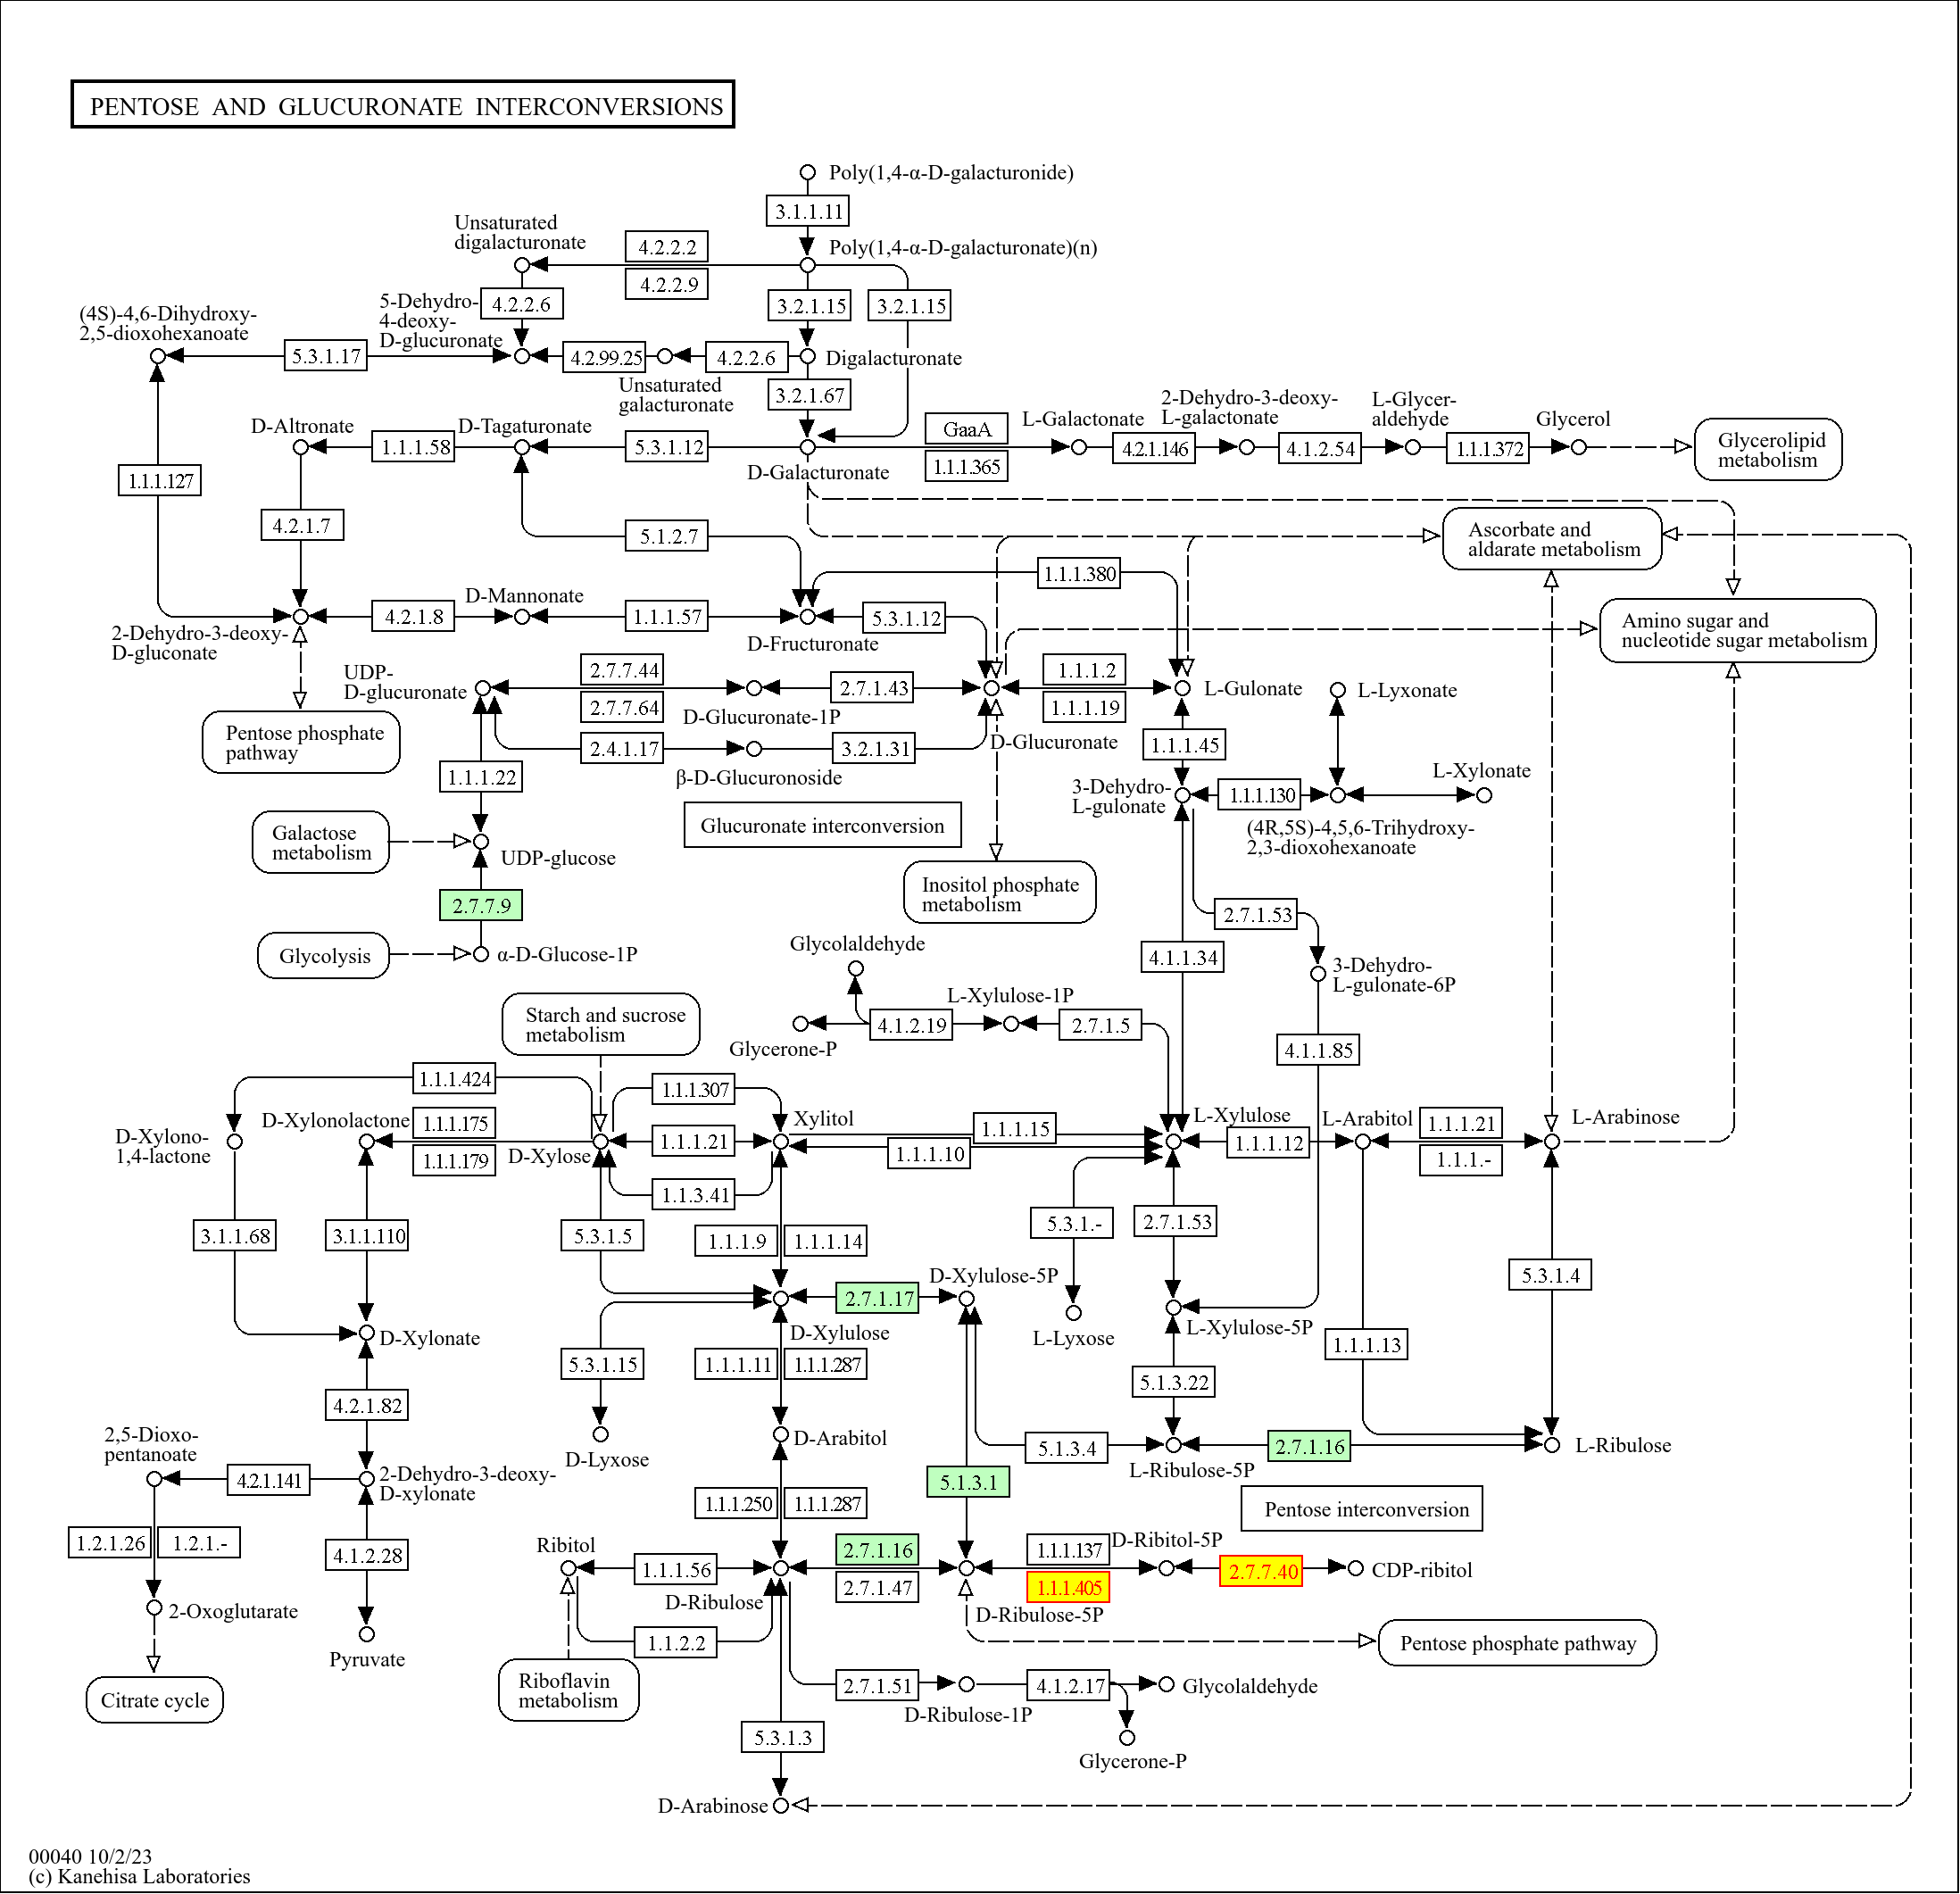

### References

Programming for KEGG (The James Hutton Institute): https://widdowquinn.github.io/2018-03-06-ibioic/02-sequence_databases/09-KEGG_programming.html

BioServices (GitHub): https://github.com/cokelaer/bioservices/blob/main/src/bioservices/kegg.py

BioServices tutorial: https://bioservices.readthedocs.io/en/main/kegg_tutorial.html#introduction